In [1]:
from IPython.core.debugger import set_trace

from keras.utils.vis_utils import model_to_dot


import sys
sys.path.append('../financial_utils/')

import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt

import performance as per

C:\Users\Jon\Anaconda3\envs\tensorflow-cpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# DATASET

### Load and Compute Returns

In [2]:
price_table = pd.read_csv('history_files/SPY.csv')
vol_table = pd.read_csv('history_files/VIX.csv')

# Build Tick Table
tick_table = price_table[['Date','Close','Open','High','Low']]
tick_table.columns = ['Date', 'Tick','Open','High','Low']
# Get Return Table
returns, other_returns = per.tick2ret_pivoted(tick_table)
data_dict = {'Date':tick_table.Date[1:], 
              'ReturnClose': returns[:,0], 'ReturnOpen': other_returns[:,0],
              'ReturnHigh': other_returns[:,1], 'ReturnLow': other_returns[:,2]}
returns_table = pd.DataFrame(data=data_dict,columns=data_dict.keys())
returns_table = returns_table.set_index('Date')

# Drop columns of Vol Table
vol_table = vol_table[['Date', 'Close','Open','High','Low']]
vol_table.columns = ['Date', 'VolClose','VolOpen','VolHigh','VolLow']
vol_table.VolClose = vol_table.VolClose/100
vol_table.VolOpen = vol_table.VolOpen/100
vol_table.VolHigh = vol_table.VolHigh/100
vol_table.VolLow = vol_table.VolLow/100
vol_table = vol_table.set_index('Date')

# InnerJoin
retvol_table = pd.concat([returns_table,vol_table], join='inner', axis=1)


In [3]:
T_x = 10
n_fields = retvol_table.shape[1]
T_y = 2
T_stride = 1

### Generate Dataset

In [4]:
def gen_dataset(T_x, T_y, n_fields, T_stride, retvol_table):
    """
    
    
    return
        x E (m, T_x)
        y E (m, T_y)
    """
    
    m = int(np.floor((returns.shape[0] - T_x) / T_stride))
    
    x = np.nan * np.ones((m-T_y*T_stride, T_x, n_fields))
    y = np.nan * np.ones((m-T_y*T_stride, T_y, n_fields))
    
    for i in range(m-T_y*T_stride):
        for j in range(retvol_table.shape[1]):
            x[i,:,j] = retvol_table.iloc[i*T_stride:i*T_stride+T_x,j].transpose()
            y[i,:,j] = retvol_table.iloc[i*T_stride+T_x:i*T_stride+T_x+T_y,j].transpose()
            
    return x, y, m

In [5]:
def normalize_data(x, params=None):
    """
    
    return 
        x_norm
        x_norm_param = (mean, std)
    """
    if params == None:
        mean = np.mean(x, axis=(0,1)) 
        std = np.std(x, axis=(0,1))
    else:
        mean = params[0]
        std = params[1]
    x_norm_param = (mean, std)
    x_norm = (x - mean)/std
    
    return x_norm, x_norm_param

In [6]:
def denormalize_data(x_norm, x_norm_param):
    """"""
    
    mean = x_norm_param[0]
    std = x_norm_param[1]
    x = x_norm * std + mean
    
    return x

In [7]:
x, y, m = gen_dataset(T_x,T_y, n_fields, T_stride,retvol_table)
x, x_norm_param = normalize_data(x)
y, _ = normalize_data(y, x_norm_param)
print('Training Example: '+str(m))
print('X Shape: '+str(x.shape))
print('Y Shape: '+str(y.shape))

Training Example: 6085
X Shape: (6083, 10, 8)
Y Shape: (6083, 2, 8)


### Train / Val / Test

In [8]:
x,y = shuffle(x,y)

train_end = int(m * 0.7)

val_end = train_end + int(0.15 * m)

x_train = x[0:train_end]
x_val = x[train_end:val_end]
x_test = x[val_end:]

y_train = y[0:train_end]
y_val = y[train_end:val_end]
y_test = y[val_end:]

# Keras Model

### Encoder- Decoder

In [15]:
keras.backend.clear_session()

n_a = 100

encoder_LSTM = keras.layers.LSTM(units = n_a, return_state=True)
decoder_LSTM = keras.layers.LSTM(units = n_a, return_state=True, return_sequences=True)

flatter = keras.layers.Flatten()
dense = keras.layers.Dense(units = 100, activation='tanh')
dropout = keras.layers.Dropout(rate = 0.75)
tanh_out = keras.layers.Dense(units = n_fields, activation='tanh')
concatenator = keras.layers.Lambda(lambda x: keras.backend.stack(x, axis=1))

In [16]:
def define_model(T_x, T_y, n_fields, n_a):
    
    x_input = keras.layers.Input(shape=(T_x, n_fields))
    output_seq = list()
    
    _, encoder_h, encoder_c = encoder_LSTM(x_input)  
    
    decoder_input = keras.layers.Input(shape=(1,n_a))
    deco_input = decoder_input
    decoder_h = encoder_h
    decoder_c = encoder_c
    
    for _ in range(T_y):
        decoder_outputs, decoder_h, decoder_c = decoder_LSTM(deco_input, initial_state=[decoder_h, decoder_c])
        decoder_outputs_flat = flatter(decoder_outputs)
        out = dense(decoder_outputs_flat)
        out = dropout(out)
        out = tanh_out(out)
        
        output_seq.append(out)
        deco_input = decoder_outputs
        
    if T_y != 1:    
        output_seq = concatenator(output_seq)
    model = keras.models.Model(inputs=[x_input, decoder_input], outputs=output_seq)
    return model

In [17]:
model = define_model(T_x, T_y, n_fields, n_a)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 8)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 100)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100), (None, 43600       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 1, 100), (No 80400       input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [18]:
optim = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optim, loss='mean_squared_error', metrics=['accuracy'])

In [19]:
epochs = 200

decoder_in = np.zeros((x_train.shape[0],1,n_a))
decoder_val = np.zeros((x_val.shape[0],1,n_a))
if T_y!=1:
    history = model.fit(x=[x_train,decoder_in], y=y_train,
              validation_data = ([x_val, decoder_val], y_val),
              shuffle=True, epochs = epochs)
else:
    history = model.fit(x=[x_train,decoder_in], y=y_train[:,0,:],
              validation_data = ([x_val, decoder_val], y_val[:,0,:]),
              shuffle=True, epochs = epochs)


Train on 4259 samples, validate on 912 samples
Epoch 1/200
4259/4259 [==============================] - 6s 1ms/step - loss: 0.6731 - acc: 0.3325 - val_loss: 0.6260 - val_acc: 0.4243
Epoch 2/200
4259/4259 [==============================] - 2s 537us/step - loss: 0.6342 - acc: 0.3687 - val_loss: 0.6246 - val_acc: 0.4364
Epoch 3/200
4259/4259 [==============================] - 2s 512us/step - loss: 0.6296 - acc: 0.3841 - val_loss: 0.6257 - val_acc: 0.4408
Epoch 4/200
4259/4259 [==============================] - 2s 504us/step - loss: 0.6278 - acc: 0.3938 - val_loss: 0.6227 - val_acc: 0.4446
Epoch 5/200
4259/4259 [==============================] - 2s 521us/step - loss: 0.6226 - acc: 0.4082 - val_loss: 0.6189 - val_acc: 0.4353
Epoch 6/200
4259/4259 [==============================] - 2s 509us/step - loss: 0.6204 - acc: 0.4066 - val_loss: 0.6219 - val_acc: 0.4479
Epoch 7/200
4259/4259 [==============================] - 2s 506us/step - loss: 0.6187 - acc: 0.4061 - val_loss: 0.6177 - val_acc: 0.4

4259/4259 [==============================] - 2s 506us/step - loss: 0.4817 - acc: 0.4637 - val_loss: 0.6183 - val_acc: 0.4529
Epoch 60/200
4259/4259 [==============================] - 2s 511us/step - loss: 0.4795 - acc: 0.4649 - val_loss: 0.6157 - val_acc: 0.4518
Epoch 61/200
4259/4259 [==============================] - 2s 504us/step - loss: 0.4760 - acc: 0.4590 - val_loss: 0.6155 - val_acc: 0.4518
Epoch 62/200
4259/4259 [==============================] - 2s 505us/step - loss: 0.4735 - acc: 0.4657 - val_loss: 0.6221 - val_acc: 0.4435
Epoch 63/200
4259/4259 [==============================] - 2s 517us/step - loss: 0.4713 - acc: 0.4678 - val_loss: 0.6130 - val_acc: 0.4496
Epoch 64/200
4259/4259 [==============================] - 2s 498us/step - loss: 0.4698 - acc: 0.4654 - val_loss: 0.6114 - val_acc: 0.4474
Epoch 65/200
4259/4259 [==============================] - 2s 505us/step - loss: 0.4640 - acc: 0.4680 - val_loss: 0.6148 - val_acc: 0.4424
Epoch 66/200
4259/4259 [=======================

4259/4259 [==============================] - 3s 810us/step - loss: 0.3878 - acc: 0.5258 - val_loss: 0.6508 - val_acc: 0.4348
Epoch 119/200
4259/4259 [==============================] - 3s 712us/step - loss: 0.3873 - acc: 0.5193 - val_loss: 0.6507 - val_acc: 0.4326
Epoch 120/200
4259/4259 [==============================] - 3s 711us/step - loss: 0.3880 - acc: 0.5222 - val_loss: 0.6475 - val_acc: 0.4380
Epoch 121/200
4259/4259 [==============================] - 3s 609us/step - loss: 0.3857 - acc: 0.5289 - val_loss: 0.6488 - val_acc: 0.4359
Epoch 122/200
4259/4259 [==============================] - 2s 566us/step - loss: 0.3856 - acc: 0.5279 - val_loss: 0.6523 - val_acc: 0.4293
Epoch 123/200
4259/4259 [==============================] - 2s 548us/step - loss: 0.3833 - acc: 0.5244 - val_loss: 0.6518 - val_acc: 0.4315
Epoch 124/200
4259/4259 [==============================] - 2s 538us/step - loss: 0.3830 - acc: 0.5349 - val_loss: 0.6532 - val_acc: 0.4265
Epoch 125/200
4259/4259 [================

4259/4259 [==============================] - 3s 648us/step - loss: 0.3523 - acc: 0.5627 - val_loss: 0.6714 - val_acc: 0.4068
Epoch 177/200
4259/4259 [==============================] - 3s 637us/step - loss: 0.3515 - acc: 0.5661 - val_loss: 0.6718 - val_acc: 0.4101
Epoch 178/200
4259/4259 [==============================] - 3s 629us/step - loss: 0.3528 - acc: 0.5680 - val_loss: 0.6690 - val_acc: 0.4046
Epoch 179/200
4259/4259 [==============================] - 3s 632us/step - loss: 0.3519 - acc: 0.5660 - val_loss: 0.6689 - val_acc: 0.4030
Epoch 180/200
4259/4259 [==============================] - 3s 634us/step - loss: 0.3505 - acc: 0.5755 - val_loss: 0.6698 - val_acc: 0.4062
Epoch 181/200
4259/4259 [==============================] - 3s 642us/step - loss: 0.3503 - acc: 0.5733 - val_loss: 0.6755 - val_acc: 0.4073
Epoch 182/200
4259/4259 [==============================] - 3s 661us/step - loss: 0.3511 - acc: 0.5686 - val_loss: 0.6754 - val_acc: 0.4035
Epoch 183/200
4259/4259 [================

<IPython.core.display.Javascript object>


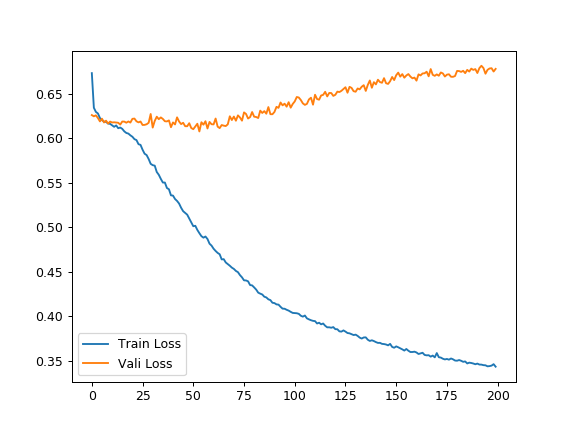

In [20]:
plt.figure()
plt.plot(history.epoch, history.history["loss"], label='Train Loss')
plt.plot(history.epoch, history.history["val_loss"], label='Vali Loss')
plt.legend()

In [ ]:
if T_y!=1:
    decoder_in = np.zeros((x_train.shape[0],1,n_a))
    evalu_test = model.evaluate(x=[x_train,decoder_in], y=y_train)
    decoder_in = np.zeros((x_val.shape[0],1,n_a))
    evalu_val = model.evaluate(x=[x_val,decoder_in], y=y_val)
else:
    decoder_in = np.zeros((x_train.shape[0],1,n_a))
    evalu_test = model.evaluate(x=[x_train,decoder_in], y=y_train[:,0,:])
    decoder_in = np.zeros((x_val.shape[0],1,n_a))
    evalu_val = model.evaluate(x=[x_val,decoder_in], y=y_val[:,0,:])
    
print('Test Error: '+ str(evalu_test))
print('Val  Error: '+ str(evalu_val))

### Visualization

In [ ]:
data_set = (x_val, y_val)
indexes = np.random.randint(0,data_set[0].shape[0], size=1)
x_in = data_set[0][indexes,:,:]
decoder_in = np.zeros((x_in.shape[0],1,n_a))
y_true = data_set[1][indexes,:,:]
y_pred = model.predict(x=[x_in,decoder_in])
y_pred_denorm = denormalize_data(y_pred, x_norm_param)
print('X:')
print(denormalize_data(x_in,x_norm_param))
print('Y:')
print(denormalize_data(y_true,x_norm_param))
print('LSTM Out:')
print(y_pred)
print('Y pred:')
print(y_pred_denorm)

In [ ]:
x_in_returns = denormalize_data(x_in,x_norm_param)[:,:,0].transpose()
x_in_vol = denormalize_data(x_in,x_norm_param)[:,:,1].transpose()
y_true_returns = denormalize_data(y_true,x_norm_param)[:,:,0].transpose()
y_true_vol = denormalize_data(y_true,x_norm_param)[:,:,1].transpose()
y_pred_returns = denormalize_data(y_pred,x_norm_param)[:,:,0].transpose()
y_pred_vol = denormalize_data(y_pred,x_norm_param)[:,:,1].transpose()
plt.figure()
plt.plot(range(0,T_x), x_in_returns, label='Input')
plt.plot(range(T_x, T_x+T_y), y_true_returns, label='Truth')
plt.plot(range(T_x, T_x+T_y), y_pred_returns, label='LSTM')
plt.title('Returns')
plt.legend()

plt.figure()
plt.plot(range(0,T_x), x_in_vol, label='Input')
plt.plot(range(T_x, T_x+T_y), y_true_vol, label='Truth')
plt.plot(range(T_x, T_x+T_y), y_pred_vol, label='LSTM')
plt.title('Vol')
plt.legend()

## SNIPPETS

### Norm - Denorm Check

In [ ]:
a, b , m = gen_dataset(T_x,T_y,T_stride,retvol_table)
x, x_norm_param = normalize_data(a)
y, _ = normalize_data(b, x_norm_param)
x = denormalize_data(x, x_norm_param)
y = denormalize_data(y, x_norm_param)

plt.figure()
plt.hist((b-y).flatten(), 100)

In [ ]:
class PlotHistory(keras.callbacks.History):
    def on_train_begin(self, logs=None):
        super().on_train_begin(logs)
        self.fig = plt.figure()
        self.axes = plt.subplot(111)
        self.trainloss_line, = self.axes.plot([],[], label='Train Loss')
        self.fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1,right=0.85, wspace=0, hspace=0) 
        self.fig.canvas.draw()
        
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        self.trainloss_line.set_data(self.epoch, self.history["loss"])
        self.axes.relim()
        self.fig.canvas.draw()
# Update of plot does not properly work